In [6]:
%%capture
!pip install tqdm
!pip install keras-tuner --upgrade

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  8


In [2]:
print(tf.__version__)

2.4.3


In [3]:
import numpy as np 
import pandas as pd 

##### Import eda initial libraries

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import os
import math
import warnings 
from datetime import datetime, date, timedelta
import pyodbc
import time
import pickle
import boto3
from io import BytesIO
import re 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image

from tqdm import tqdm

In [5]:
##### check path with folder images

In [6]:
import os

In [7]:
os.getcwd()

'/home/ec2-user/SageMaker/DAAN 570/Lesson VIII'

In [115]:
import os
for dirname, _, filenames in os.walk('/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00297.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00943.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00033.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00275.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00113.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00184.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00353.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00104.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00393.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00081.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00037.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00338.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00004.jpg
/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/image

In [9]:
##### check some images

In [10]:
# path to images
path = '/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/'

# animal categories
categories = ['dogs', 'panda', 'cats']

In [11]:
##### Number of images per category

In [12]:
print('Total cats images:', len(os.listdir(path + 'cats')))
print('Total dogs images:', len(os.listdir(path + 'dogs')))
print('Total pandas images:', len(os.listdir(path + 'panda')))

Total cats images: 1000
Total dogs images: 1000
Total pandas images: 1000


In [50]:
path+category

'/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/cats'

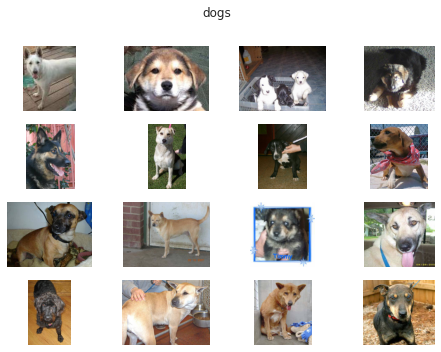

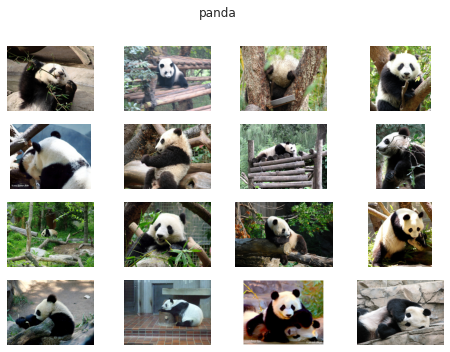

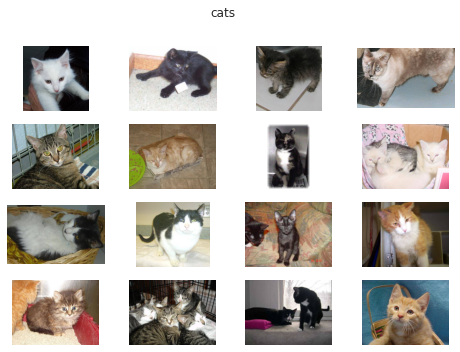

In [48]:
for category in categories:
    fig, _ = plt.subplots(4,4)
    fig.suptitle(category)
    for k, v in enumerate(os.listdir(path+category)[:16]):
        img = plt.imread(path+category+'/'+v)
        plt.subplot(4, 4, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [14]:
##### Explore images Shape by animal categories

In [15]:
shape0 = []
shape1 = []

for category in categories:
    for files in os.listdir(path+category):
        shape0.append(plt.imread(path+category+'/'+ files).shape[0])
        shape1.append(plt.imread(path+category+'/'+ files).shape[1])
    print(category, ' => height min : ', min(shape0), 'width min : ', min(shape1))
    print(category, ' => height max : ', max(shape0), 'width max : ', max(shape1))
    shape0 = []
    shape1 = []

dogs  => height min :  50 width min :  59
dogs  => height max :  500 width max :  500
panda  => height min :  87 width min :  78
panda  => height max :  1200 width max :  1600
cats  => height min :  32 width min :  55
cats  => height max :  500 width max :  500


In [15]:
##### Based on the above we need reshape to uniform for all categories

In [16]:
##### Load data and resized using Keras approach

In [16]:
from tensorflow.keras import backend as k
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [17]:
train_datagen = ImageDataGenerator(
                fill_mode = 'nearest',
                validation_split=0.20
)


In [18]:
import time

start = time.time()

train_generator=train_datagen.flow_from_directory(
    path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
)
validation_generator=train_datagen.flow_from_directory(
    path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
)

end = time.time()

print(end - start)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
0.21973967552185059


In [19]:
train_generator.target_size

(108, 108)

In [20]:
##### Check class indices 
validation_generator.class_indices

{'cats': 0, 'dogs': 1, 'panda': 2}

In [21]:
train_generator.class_indices

{'cats': 0, 'dogs': 1, 'panda': 2}

#####  Using transfer learning 

###### Option 2: Build a model from a pre-trained model using transfer learning 
###### ( VGG 19 or ResNet50 model for example). Adapt your model to the image size (for example 108x108x3) 
###### and outputs (keras API has already a list of built-in pretrained deep networks).

In [22]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    def rn50_model_build_daan570():
        model = tf.keras.models.Sequential([
    ResNet50(input_shape=(108,108,3), include_top=False),
])
        for layer in model.layers:
            layer.trainable = False
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(3, activation='softmax')) ##### Dense 3 == number of classes
        model.summary()
        return model
        

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [23]:
model = rn50_model_build_daan570()

Extension horovod.torch has not been built: /home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-10-12 16:11:44.605 ip-172-16-64-253.ec2.internal:101434 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-10-12 16:11:44.630 ip-172-16-64-253.ec2.internal:101434 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in d

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 64)          1179712   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [25]:
##### Total params: 24,771,779

In [ ]:
##### Trainable params: 1,184,067

In [26]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [27]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)

In [28]:
import time

start = time.time()

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=20,
                    verbose=1,
                    batch_size=64
                    )

end = time.time()

print(end - start)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

##### Plot evaluation metrics 

In [29]:
from pandas import option_context

with option_context('display.max_rows', 3000,'display.max_colwidth', 200,'display.max_columns',50):
              display(pd.DataFrame(model.history.history).head(10))

,loss,accuracy,val_loss,val_accuracy
0,1.273727,0.772083,0.353231,0.893333
1,0.340294,0.898333,0.387074,0.881667
2,0.204826,0.927917,0.309303,0.906667
3,0.138071,0.950417,0.273097,0.915000
4,0.109226,0.964583,0.332601,0.915000
5,0.064016,0.978333,0.441561,0.908333
6,0.063420,0.978333,0.363866,0.886667
7,0.061117,0.981667,0.426667,0.905000
8,0.036072,0.989167,0.461667,0.901667
9,0.026774,0.992083,0.676422,0.888333


In [30]:
_, acc = model.evaluate(validation_generator, verbose=1)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

In [46]:

print(' Validation Accuracy of our fine tuned model is: ', acc)

 Validation Accuracy of our fine tuned model is:  0.925000011920929


In [45]:
print("Training Accuracy is: ",format(history.history['accuracy'][-1],".2f"))

Training Accuracy is:  0.98


##### Our restnet model achieved the following results in our test / validation set:

##### accuracy = 0.9250
#####  loss = 0.6268 
#####  In terms of training time I was able to set up a multi GPU training strategy,
##### total training time was : 219.39531254768372  sec

##### Plot training & validation accuracy / loss values

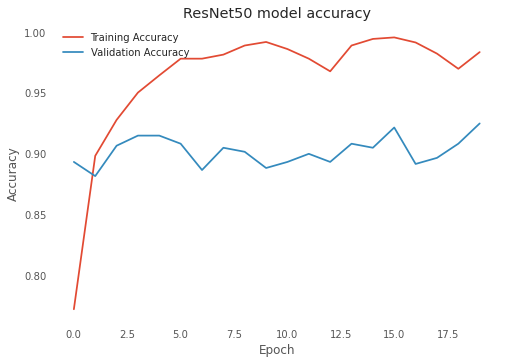

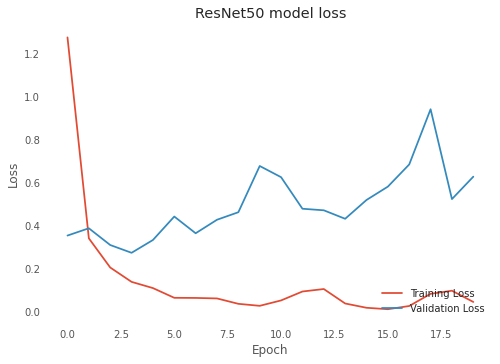

In [33]:

figsize = (25, 12)
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='white'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

#### Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

######  The training loss was decreasing are the number of epochs were increasing
##### The validation accuracy was stable as the number of epachs were increasing but we could train for more epochs
##### with of course the risk of some overfitting

###### save model 

In [53]:
os.getcwd()

'/home/ec2-user/SageMaker/DAAN 570/Lesson VIII'

In [54]:
model.save('/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/model/modelrestnet50.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

##### Test some predictions for each class 

In [65]:
import cv2

In [93]:
test_data=[]
test_image_o = cv2.imread('/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/cats/cats_00907.jpg')
test_image = cv2.resize(test_image_o, (108, 108))  # .flatten()
test_data.append(test_image)

##### Index classes

In [103]:
index_class = {v:s for s,v in train_generator.class_indices.items()}

In [104]:
index_class

{0: 'cats', 1: 'dogs', 2: 'panda'}

In [79]:
path_test = '/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/cats/cats_00907.jpg'

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op M

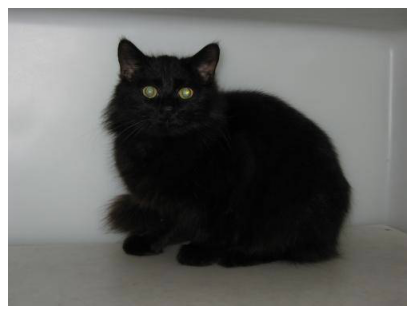

In [120]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/cats/cats_00907.jpg',
                            target_size=(108,108))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

##### Make prediction with model


result =np.argmax( model.predict(test_image))
print(f"Predicted {index_class[result]}!")
plt.imshow(plt.imread(path_test))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
#

###### Test Panda image#######

In [109]:
path_test1 = '/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/panda/panda_00966.jpg'

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op M

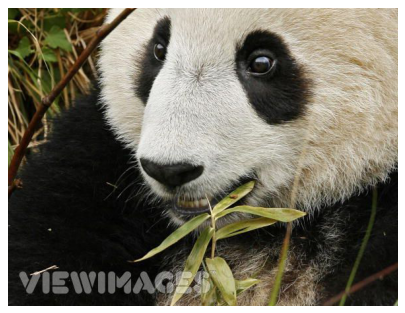

In [121]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image1 = image.load_img('/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/panda/panda_00966.jpg',
                            target_size=(108,108))
test_image1 = image.img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1, axis = 0)

##### Make prediction with model


result1 =np.argmax( model.predict(test_image1))
print(f" Predicted {index_class[result1]}!")
plt.imshow(plt.imread(path_test1))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

###### Test Dog image#######

In [111]:
path_test2 = '/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00004.jpg'

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op M

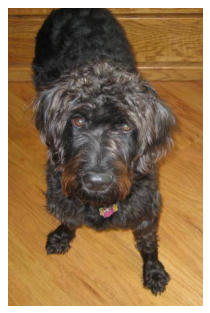

In [122]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image2 = image.load_img('/home/ec2-user/SageMaker/DAAN 570/Lesson VIII/images/dogs/dogs_00004.jpg',
                            target_size=(108,108))
test_image2 = image.img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis = 0)

##### Make prediction with model


result2 =np.argmax( model.predict(test_image2))
print(f"Predicted {index_class[result2]}!")
plt.imshow(plt.imread(path_test2))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

##### We could further improve our model by using Image Augmentation and tuning our learning rate

###### Image augmentation is a technique to create new artificial training data from the existing data. 
######  Image Augmentation changes the original training image by scaling, rotating, cropping, and flipping it. 
###### It artificially creates images for training.